<a href="https://colab.research.google.com/github/RAGISHIVANAND/WEATHER-FORECAST-/blob/main/Weather_forecast_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from torch import nn,optim

import torch.nn.functional as F

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

sns.set(style= 'whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#93D30C","#8F00FF"]

#HAPPY_COLORS_PALETTE = ["blue","yellow","orange","pink","green","purple"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12,8

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

In [2]:
def ann_viz(model,view=True,filename="network.gv"):

    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer=0
    layers=[layer for layer in model.modules() if type(layer)== torch.nn.Linear]


    for layer in layers:
        if layer == layers[0]:
            input_layer=layer.in_features
            hidden_layers_nr += 1
            if type(layer)==torch.nn.Linear:
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")
        else:
            if layer ==layers[-1]:
                output_layer=layer.out_features
            else:
                hidden_layers_nr +=1
                if type(layer)==torch.nn.Linear:
                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")

        last_layer_nodes=input_layer
        nodes_up = input_layer

    g=Digraph("g",filename=filename)

    n=0
    g.graph_attr.update(splines="false",nodesep="0.5",ranksep="0",rankdir='LR')

    #Input layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0])==torch.nn.Linear:
            the_label="Input Layer"
            if layers[0].in_features>10:
                the_label+="(+"+str(layers[0].in_features-10)+")"
                input_layer=10
            c.attr(color="white")
            for i in range(0,input_layer):
                n+=1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label,labelloc="bottom")
                c.attr(rank="same")
                c.node_attr.update(
                    width="0.65",
                    style="filled",
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0,hidden_layers_nr):
        with g.subgraph(name="cluster_"+str(i+1)) as c:
            if layer_types[i]=="Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label=f'Hidden Layer{i+1}'
                if layers[i].out_features>10:
                    the_label+="(+"+str(layers[i].out_features-10)+")"
                    hidden_layers[i]=10
                c.attr(labeljust="right",labelloc="b",label=the_label)
                for j in range(0,hidden_layers[i]):
                    n+=1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],

                    )
                    for h in range(nodes_up-last_layer_nodes+1,nodes_up+1):
                        g.edge(str(h),str(n))
                last_layer_nodes=hidden_layers[i]
                nodes_up+=hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1])==torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1,output_layer+1):
                n+=1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                )
                for h in range(nodes_up-last_layer_nodes+1,nodes_up+1):
                    g.edge(str(h),str(n))
            c.attr(label="Output Layer",labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71",style="filled",fontcolor="#2ecc71",shape="circle"
                #color="green",style="filled,fontcolor="green",shape="circle"

            )
    g.attr(arrowshape="none")
    g.edge_attr.update(arrowhead="none",color="#707070",penwidth="2")
    #g.edge_attr.update(arrowhead="none",color="gray",penwidth="2")
    if view is True:
        g.view()
    return g




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/MyDrive/weather_aus.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-01-2013,Albury,13.1,35.5,0.0,NaN,NaN,W,44.0,SE,...,49.0,16.0,1012.8,1009.3,NaN,NaN,22.3,32.7,No,No
1,01-01-2013,BadgerysCreek,17.4,37.4,0.0,NaN,NaN,E,35.0,ENE,...,73.0,36.0,1011.8,1006.9,NaN,NaN,24.0,35.0,No,No
2,01-01-2013,Cobar,23.6,40.2,0.0,12.4,NaN,WNW,43.0,N,...,21.0,8.0,1012.7,1008.9,1.0,2.0,31.5,38.9,No,No
3,01-01-2013,CoffsHarbour,21.1,32.1,0.0,9.6,NaN,NE,48.0,N,...,NaN,NaN,1015.2,1011.5,3.0,6.0,27.1,29.0,No,No
4,01-01-2013,Moree,21.1,34.8,0.0,11.4,12.0,NE,33.0,N,...,58.0,29.0,1016.2,1011.8,6.0,6.0,24.1,32.0,No,No


In [5]:
df.shape

(145399, 23)

In [6]:
cols=['Rainfall','Humidity3pm','Pressure9am','RainToday','RainTomorrow']

df = df[cols]

In [7]:
df['RainToday'].replace({'No':0,'Yes':1},inplace=True)
df['RainTomorrow'].replace({'No':0,'Yes':1},inplace=True)

<ipython-input-7-961e6da6005f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainToday'].replace({'No':0,'Yes':1},inplace=True)


In [8]:
df=df.dropna(how='any')
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.0,16.0,1012.8,0.0,0.0
1,0.0,36.0,1011.8,0.0,0.0
2,0.0,8.0,1012.7,0.0,0.0
4,0.0,29.0,1016.2,0.0,0.0
6,0.0,76.0,1012.2,0.0,0.0


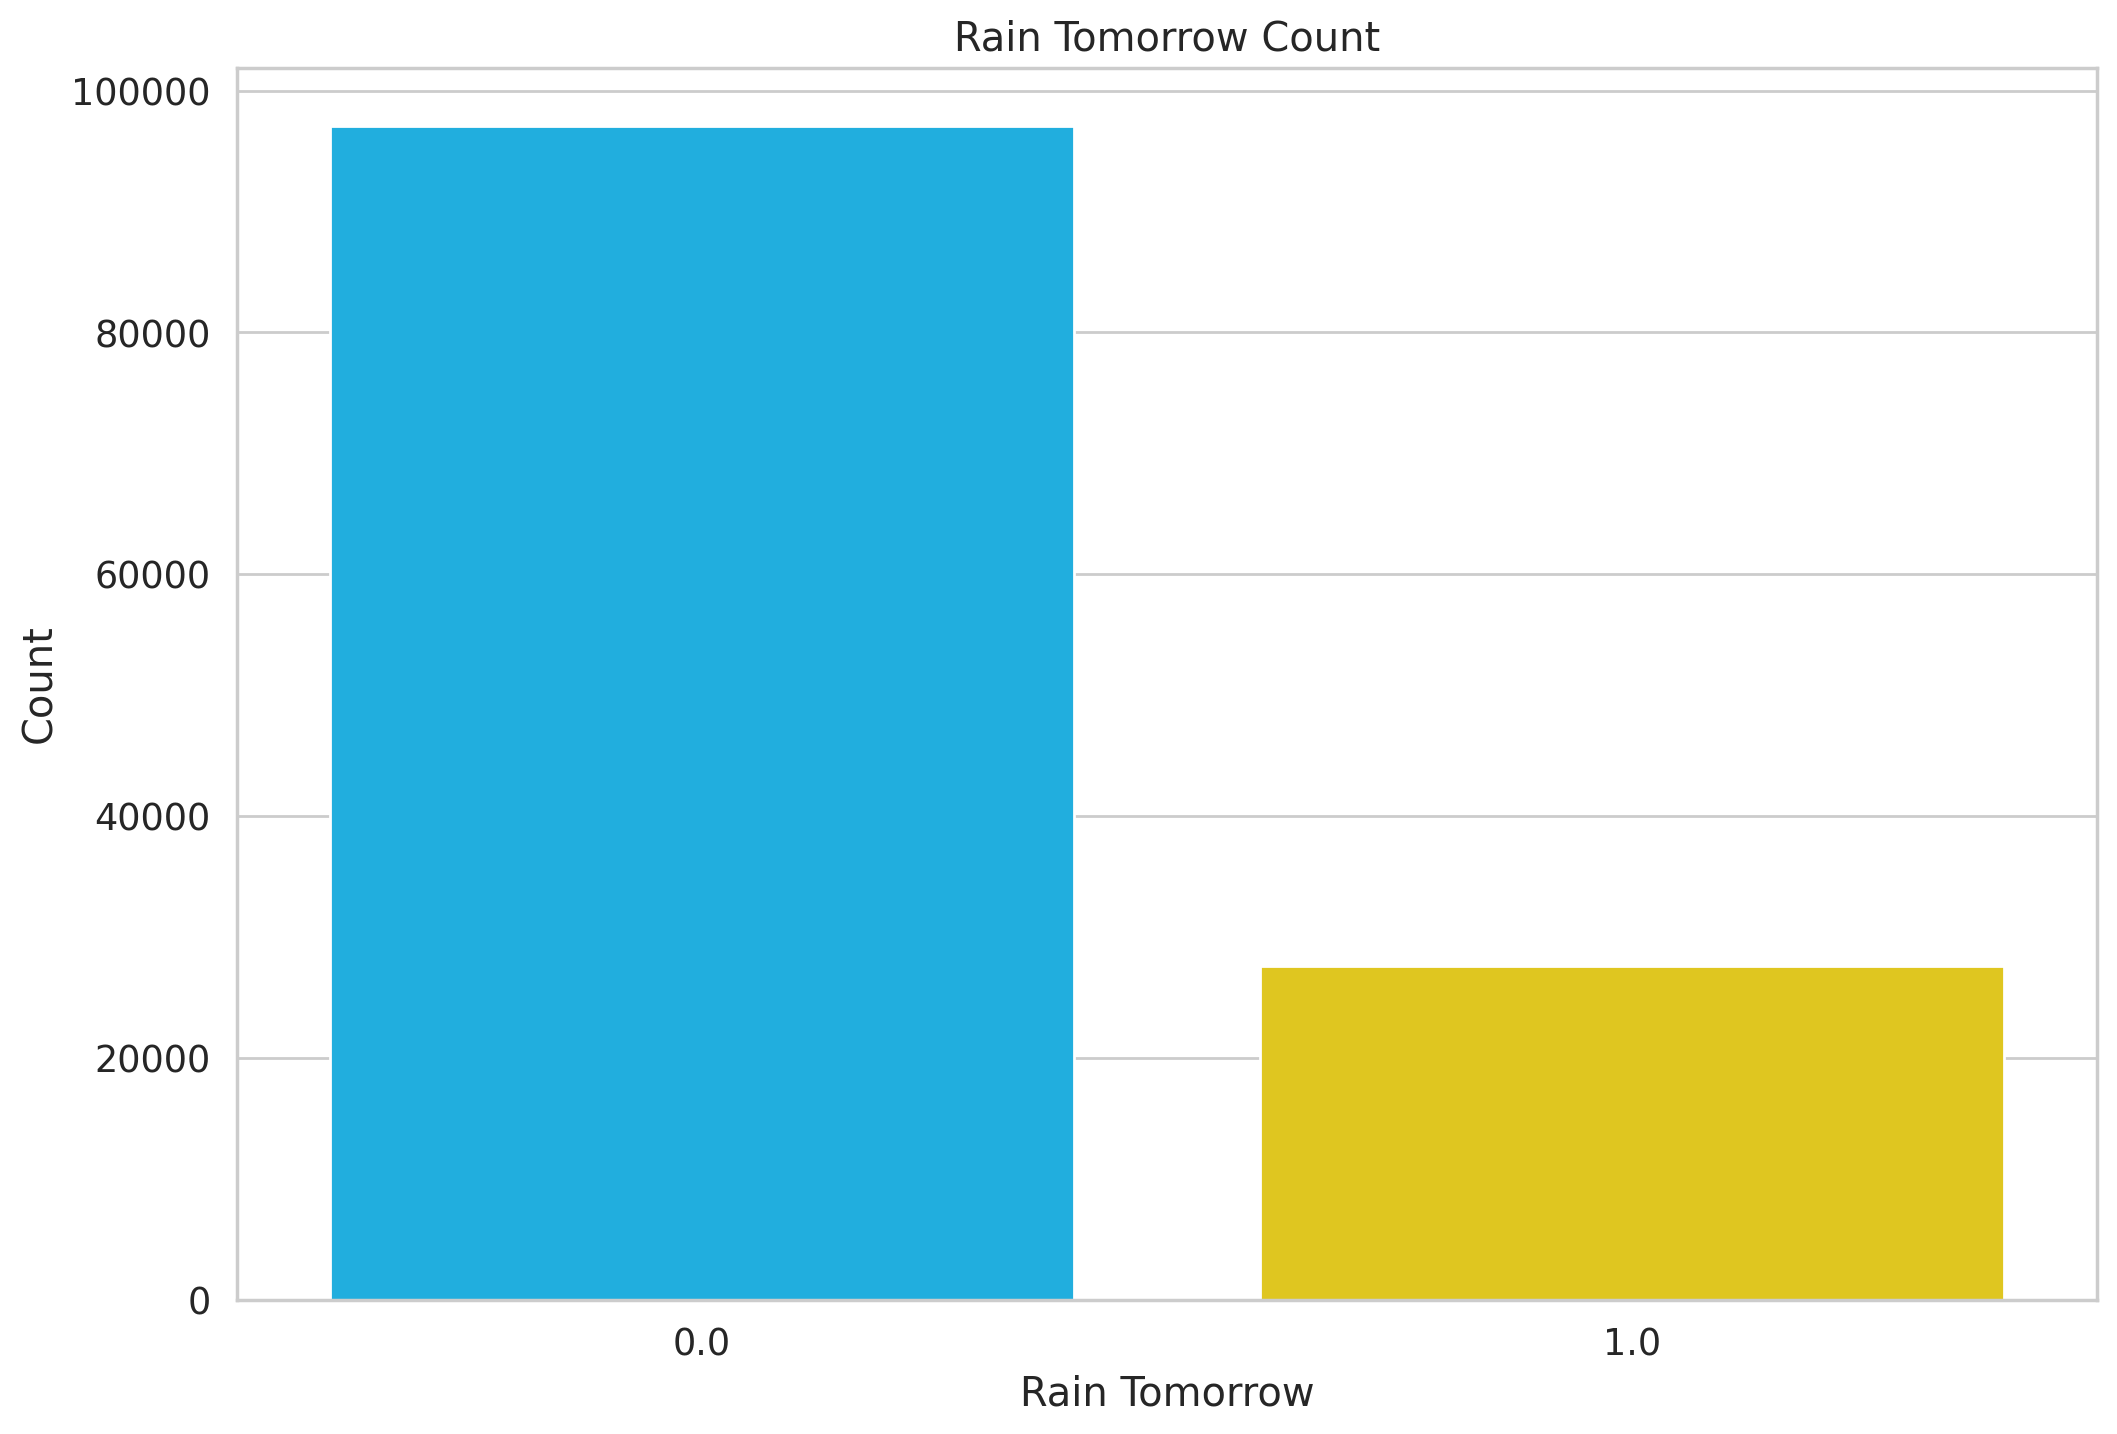

In [9]:
#sns.countplot(df.RainTomorrow);
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called df with a column named "RainTomorrow"

# Set up the figure and axes
fig, ax = plt.subplots()

# Create the count plot
sns.countplot(data=df, x='RainTomorrow', ax=ax)

# Customize the plot
ax.set_title('Rain Tomorrow Count')
ax.set_xlabel('Rain Tomorrow')
ax.set_ylabel('Count')

# Show the plot
plt.show()


In [10]:
df.RainTomorrow.value_counts()/df.shape[0]

0.0    0.778806
1.0    0.221194
Name: RainTomorrow, dtype: float64

In [11]:
x = df[['Rainfall','Humidity3pm','RainToday','Pressure9am']]
y=df[['RainTomorrow']]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=RANDOM_SEED)

In [12]:
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


torch.Size([99702, 4]) torch.Size([99702])
torch.Size([24926, 4]) torch.Size([24926])


In [13]:
class Net(nn.Module):
  def __init__(self,n_features):
    super(Net,self).__init__()
    self.fc1=nn.Linear(n_features,5)
    self.fc2=nn.Linear(5,3)
    self.fc3=nn.Linear(3,1)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

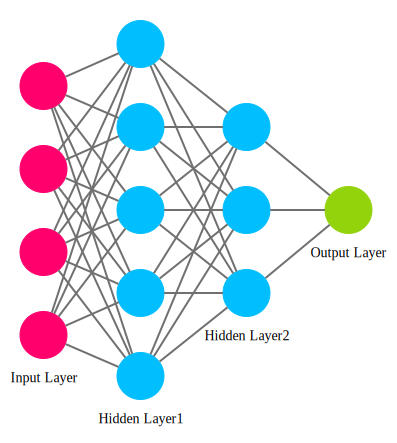

In [14]:

net = Net(x_train.shape[1])
ann_viz(net,view=False)

# ***RELU GRAPH***

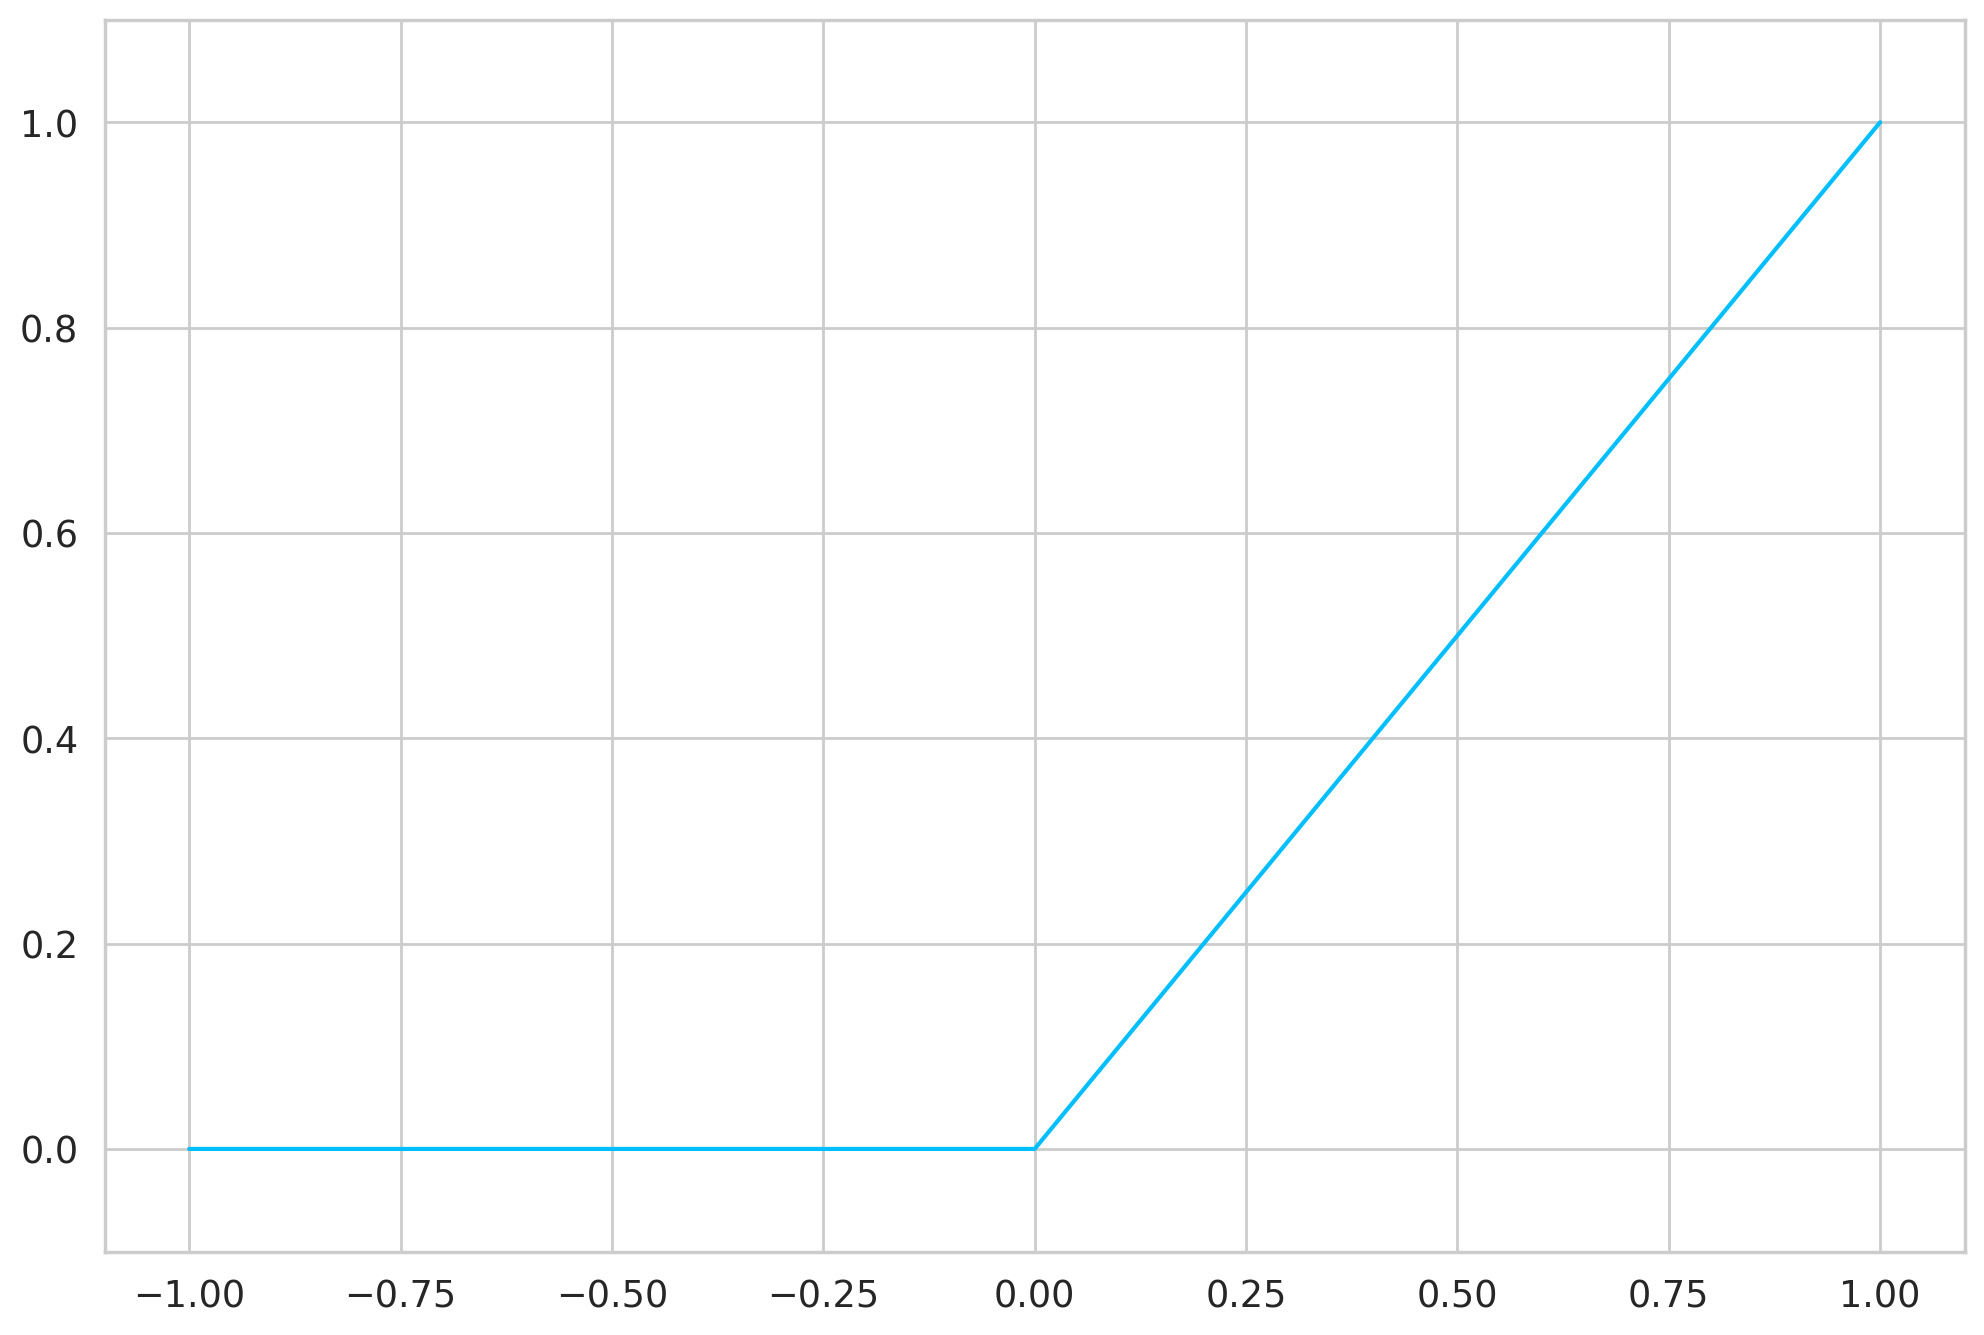

In [15]:
ax = plt.gca()
plt.plot(
  np.linspace(-1,1,5),
  F.relu(torch.linspace(-1,1,steps=5)).numpy()
)
ax.set_ylim([-0.1,1.1]);

# ***SIGMOID GRAPH***

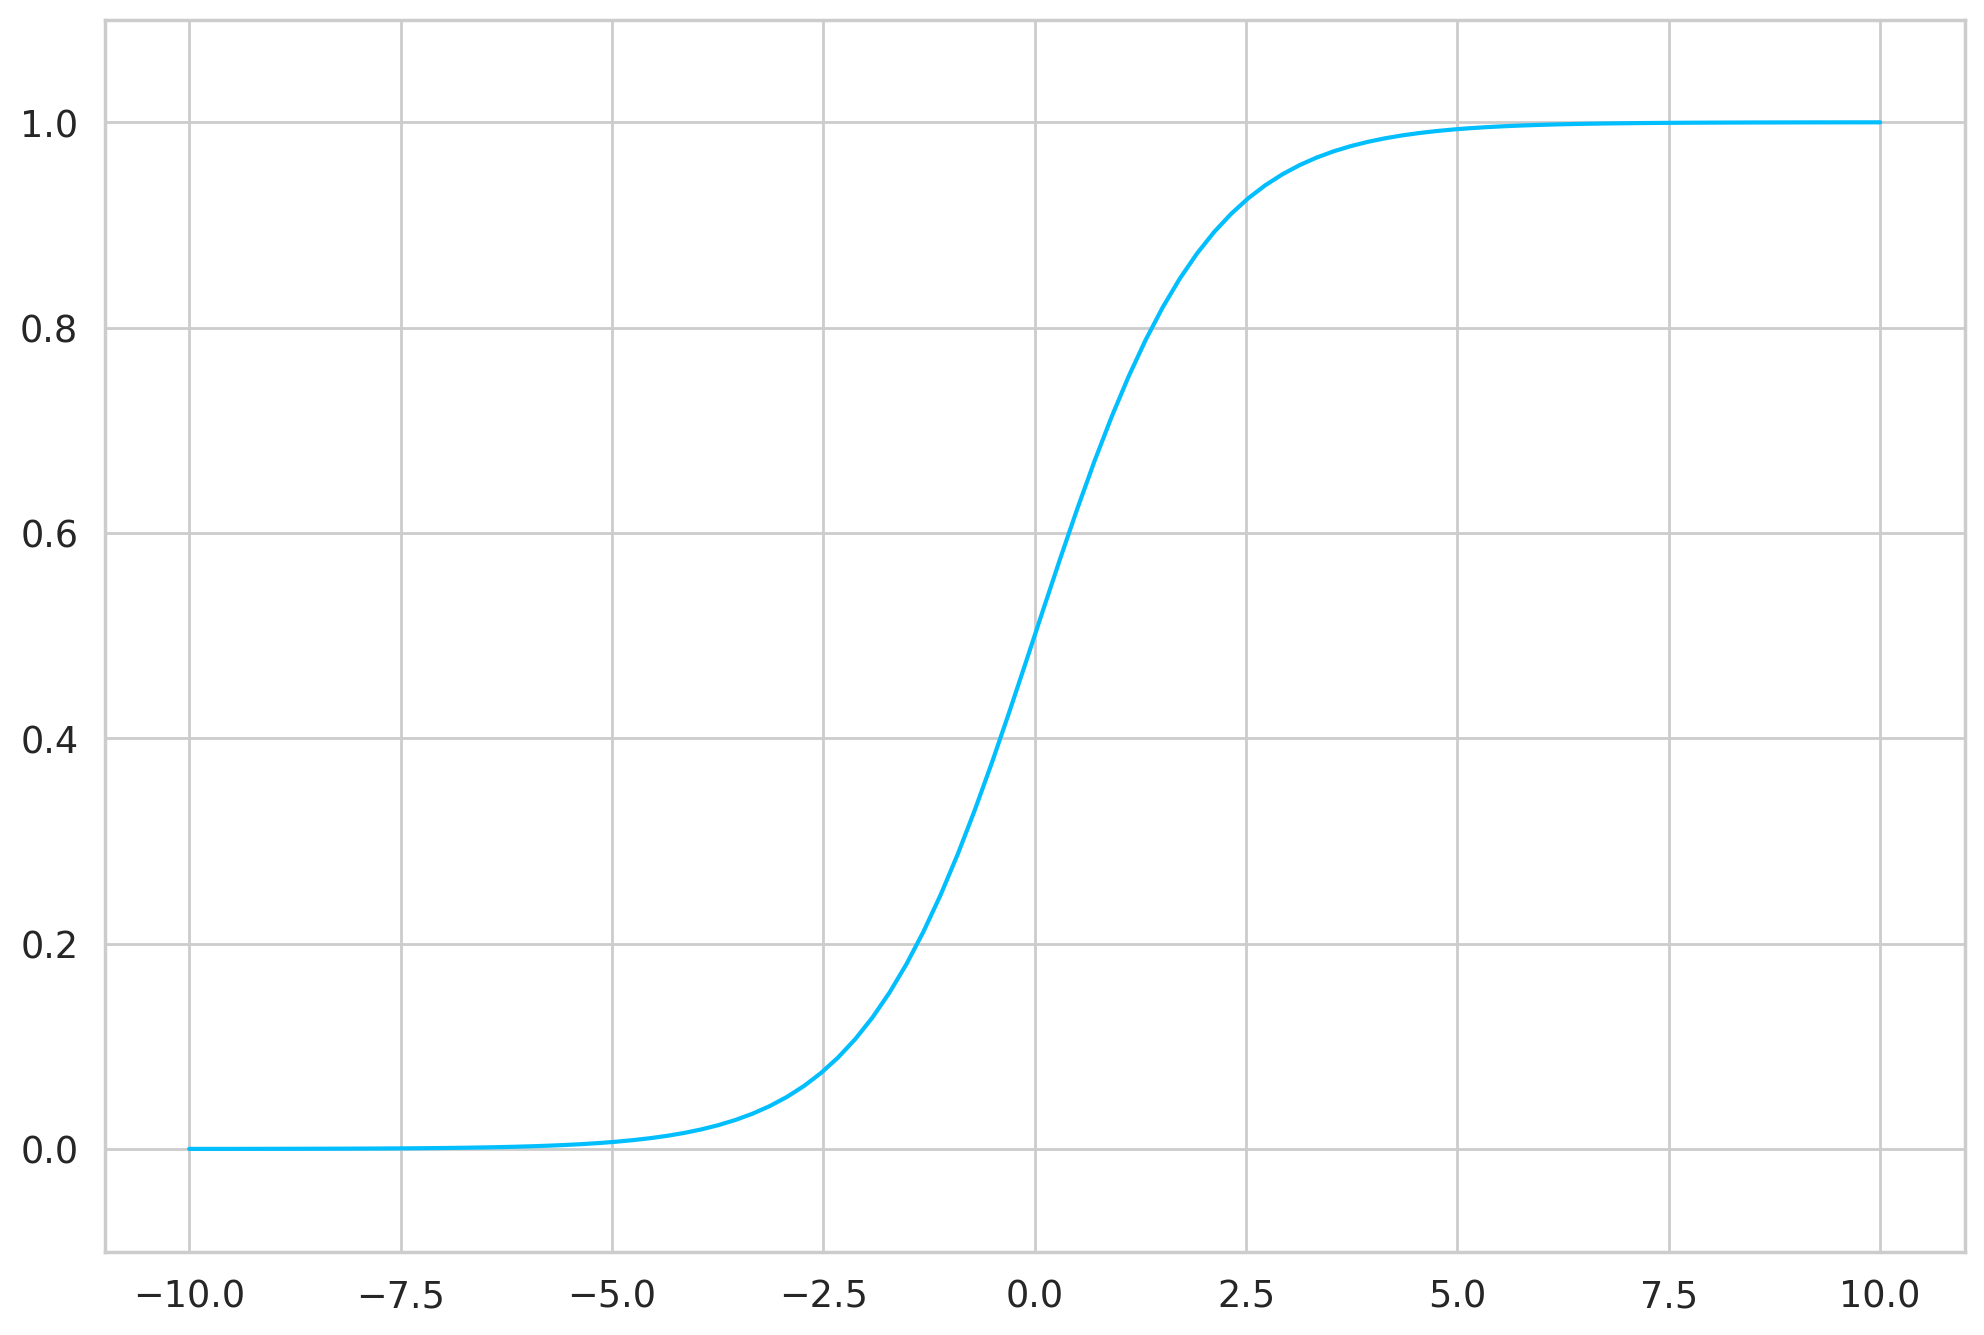

In [16]:
ax=plt.gca()
plt.plot(
  np.linspace(-10,10,100),
  torch.sigmoid(torch.linspace(-10,10,steps=100)).numpy()
)
ax.set_ylim([-0.1,1.1]);


# ***Taking the binary cross entropy***

In [17]:
criterion=nn.BCELoss()

In [18]:
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [19]:
device = torch.device("cuda:0"if torch.cuda.is_available()else"cpu")

In [20]:
x_train=x_train.to(device)
y_train=y_train.to(device)

x_test=x_test.to(device)
y_test=y_test.to(device)


In [21]:
net = net.to(device)
criterion=criterion.to(device)

# ***Now we are calculating the accuracy***

In [22]:
def calculate_accuracy(y_true,y_pred):
  predicted=y_pred.ge(.5).view(-1)
  return(y_true==predicted).sum().float()/len(y_true)

In [23]:
def round_tensor(t,decimal_places=3):
  return round(t.item(),decimal_places)

for epoch in range(1000):
    y_pred = net(x_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred,y_train)

    if epoch% 100 == 0:
      train_acc = calculate_accuracy(y_train,y_pred)

      y_test_pred=net(x_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred,y_test)
      test_acc = calculate_accuracy(y_test,y_test_pred)

      print(


f'''epoch{epoch}
Train set - loss:{round_tensor(train_loss)},accuracy:{round_tensor(train_acc)}
Train set - loss:{round_tensor(test_loss)},accuracy:{round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch0
Train set - loss:2.512,accuracy:0.779
Train set - loss:2.516,accuracy:0.779

epoch100
Train set - loss:0.458,accuracy:0.792
Train set - loss:0.456,accuracy:0.794

epoch200
Train set - loss:0.435,accuracy:0.8
Train set - loss:0.433,accuracy:0.801

epoch300
Train set - loss:0.417,accuracy:0.816
Train set - loss:0.416,accuracy:0.817

epoch400
Train set - loss:0.408,accuracy:0.828
Train set - loss:0.407,accuracy:0.83

epoch500
Train set - loss:0.404,accuracy:0.832
Train set - loss:0.403,accuracy:0.834

epoch600
Train set - loss:0.402,accuracy:0.834
Train set - loss:0.401,accuracy:0.836

epoch700
Train set - loss:0.401,accuracy:0.835
Train set - loss:0.4,accuracy:0.836

epoch800
Train set - loss:0.401,accuracy:0.835
Train set - loss:0.399,accuracy:0.837

epoch900
Train set - loss:0.401,accuracy:0.835
Train set - loss:0.399,accuracy:0.837



# ***SAVING THE MODEL***

In [24]:
MODEL_PATH = 'model.path'

torch.save(net,MODEL_PATH)

# ***LOADING THE MODEL***

In [25]:
net = torch.load(MODEL_PATH)

In [26]:
classes = ['No rain', 'Raining']

y_pred = net(x_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))


              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19406
     Raining       0.74      0.41      0.53      5520

    accuracy                           0.84     24926
   macro avg       0.80      0.68      0.71     24926
weighted avg       0.83      0.84      0.82     24926



Text(0.5, 51.249999999999986, 'Predicted label')

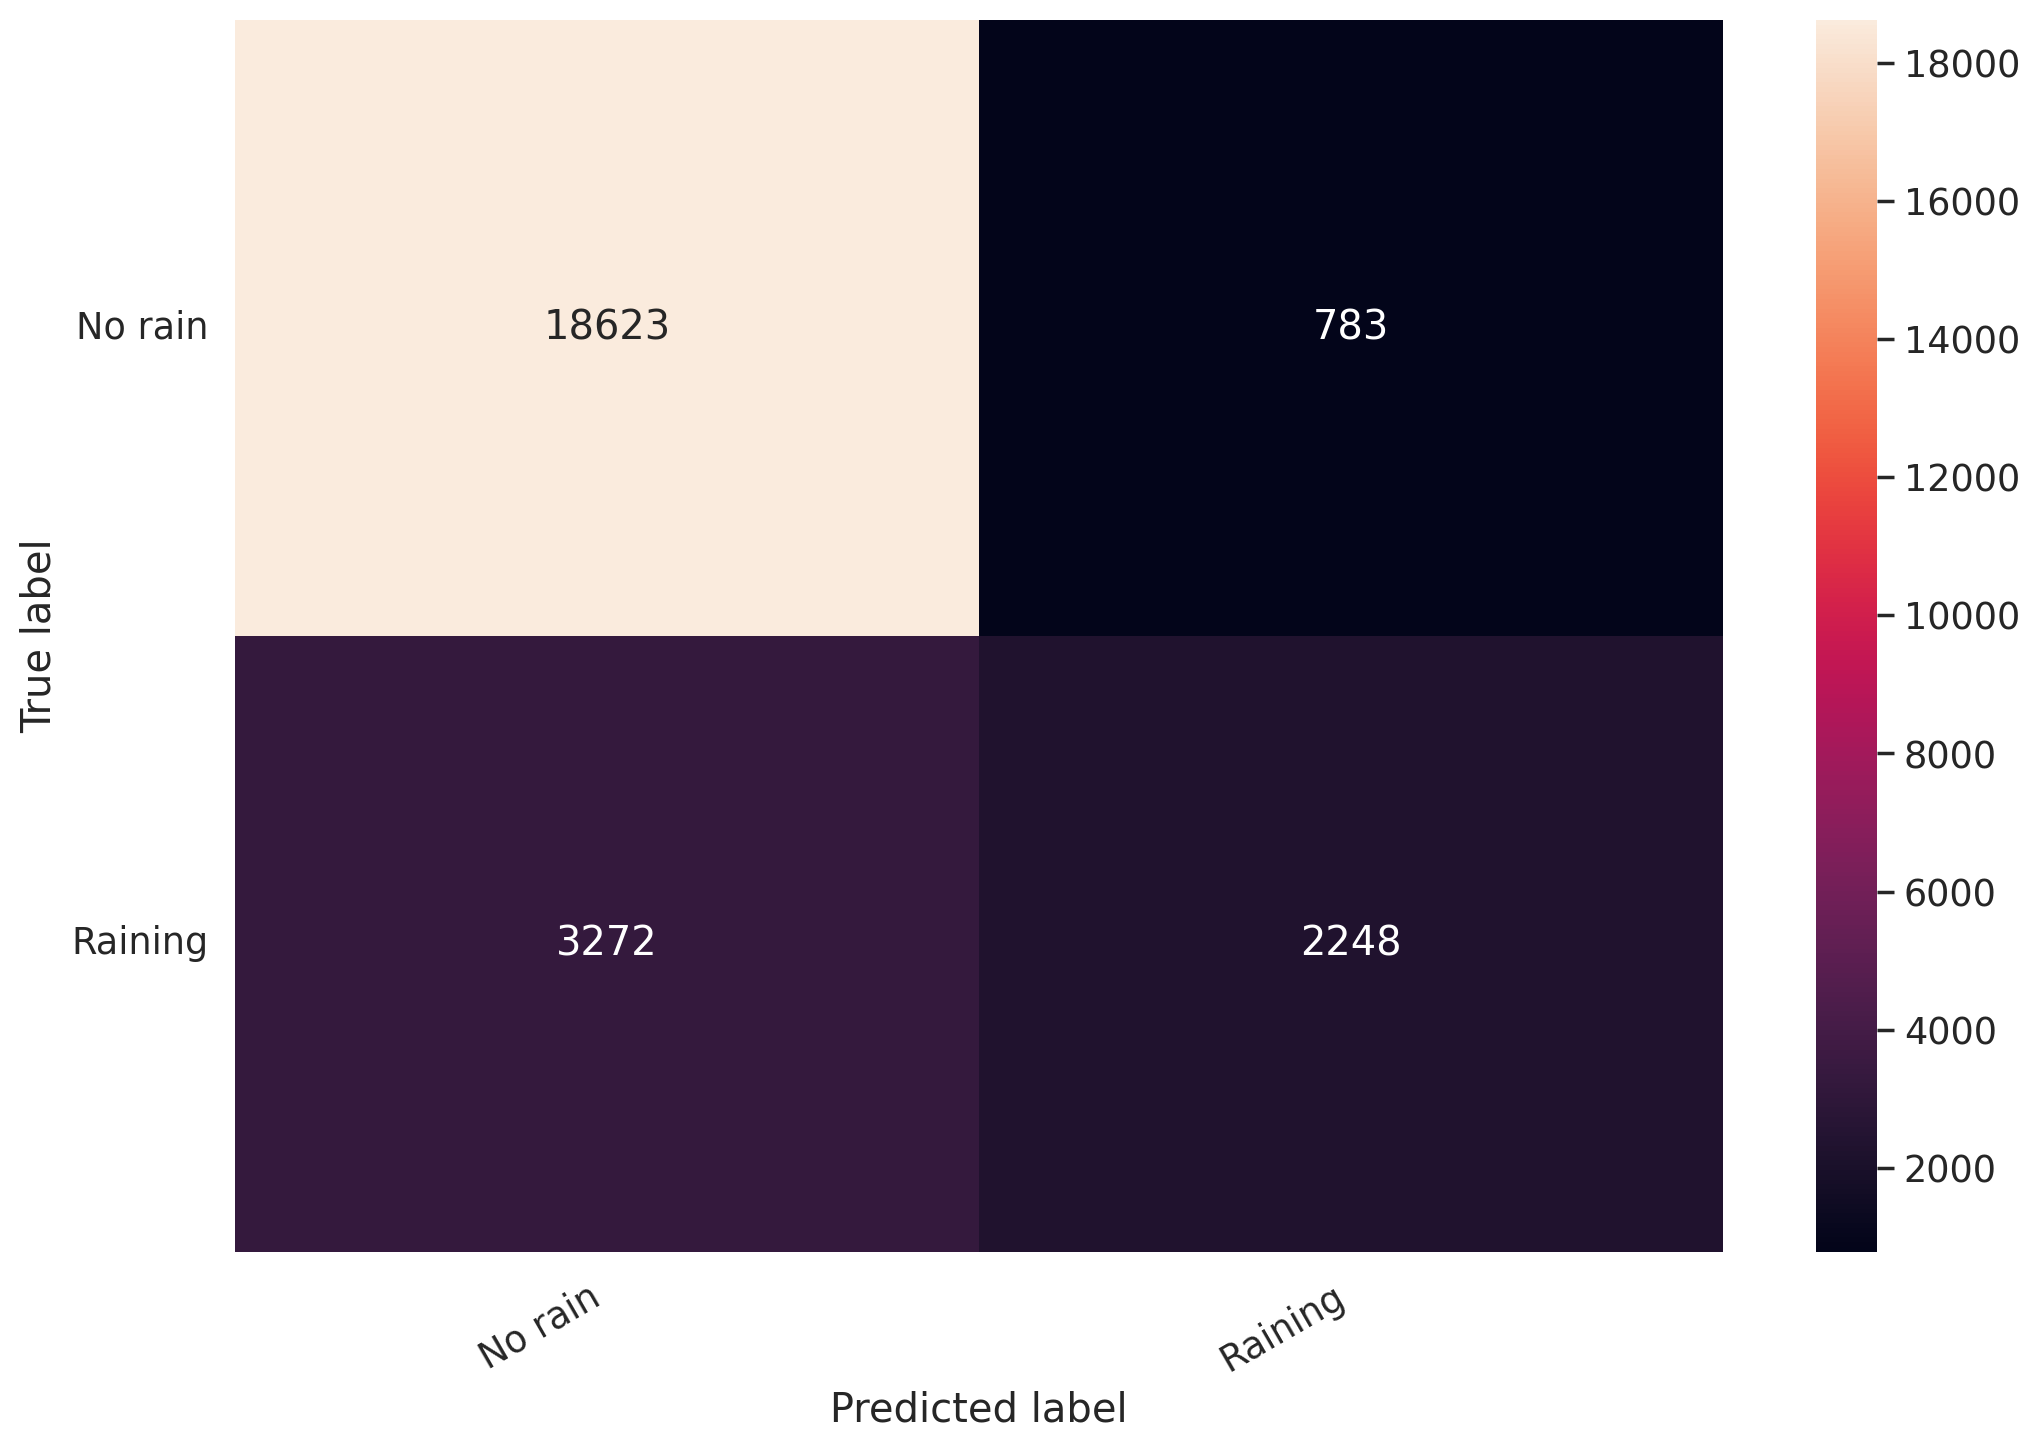

In [27]:
cm=confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(cm,index=classes,columns=classes)

hmap=sns.heatmap(df_cm,annot=True,fmt="d")

hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha='right')

hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30,ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')



In [28]:
def will_it_rain(rainfall,humidity,raintoday,pressure):
  t = torch.as_tensor([rainfall,humidity,rain_today,pressure])\
      .float()\
      .to(device)
  output=net(t)
  return output.ge(0.5).item()

In [38]:
prediction = will_it_rain(rainfall=10, humidity=10, raintoday=1, pressure=2)
print(prediction)


True


In [37]:
prediction = will_it_rain(rainfall=0, humidity=1, raintoday=0, pressure=100)
print(prediction)


False
